In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 1.このSprintについて

### Sprintの目的
系列データに関する応用例を学ぶ

### どのように学ぶか
公開されているコードを元に学んでいきます。

# 2.機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。

# 【問題1】機械翻訳の実行とコードリーディング¶
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。  
  
keras/lstm_seq2seq.py ：　https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py. 
  
その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。  
  
### （例）
51から55行目 : ライブラリのimport.   
57から62行目 : ハイパーパラメータの設定. 
### 《文字単位のトークン化》
この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。  
scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。  
charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [2]:
pwd

'/content'

In [3]:
%cd /content/

/content


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
#データをダウンロード
!wget http://www.manythings.org/anki/fra-eng.zip

--2020-07-19 10:13:26--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 172.67.173.198, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6041598 (5.8M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   5.76M  14.7MB/s    in 0.4s    

2020-07-19 10:13:27 (14.7 MB/s) - ‘fra-eng.zip’ saved [6041598/6041598]



In [7]:
#zipファイルを解凍
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [8]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 57s 7ms/step - loss: 1.1796 - accuracy: 0.7248 - val_loss: 1.0651 - val_accuracy: 0.7190
Epoch 2/100
8000/8000 [==============================] - 55s 7ms/step - loss: 0.8574 - accuracy: 0.7697 - val_loss: 0.8503 - val_accuracy: 0.7631
Epoch 3/100
8000/8000 [==============================] - 55s 7ms/step - loss: 0.6833 - accuracy: 0.8075 - val_loss: 0.7239 - val_accuracy: 0.7876
Epoch 4/100
8000/8000 [==============================] - 56s 7ms/step - loss: 0.5969 - accuracy: 0.8263 - val_loss: 0.6596 - val_accuracy: 0.8054
Epoch 5/100
8000/8000 [==============================] - 56s 7ms/step - loss: 0.5458 - accuracy: 0.8409 - val_loss: 0.6095 - val_accuracy: 0.8192
Epoch 6/100
8000/8000 [==============================] - 

### 44から48行目 : ライブラリのimport  
### 50から55行目 : ハイパーパラメータの設定  
### 58から89行目 : データをベクトル化  
### 96から104行目 ：エンコーダとデコーダを設定
### 106から149行目 ：モデルを定義して学習
### 160行目 ：予測


# 3.イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。  
  
pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial. 
  
イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。  
  
# 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。  
  
データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。  
  
注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

## 「sample.py」の以下のコードを変更
### 変更前
```python
    parser.add_argument('--encoder_path', type=str, default='models/encoder-5-3000.pkl', help='path for trained encoder')
    parser.add_argument('--decoder_path', type=str, default='models/decoder-5-3000.pkl', help='path for trained decoder')
    parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', help='path for vocabulary wrapper')
```
  
### 変更後
```python
    parser.add_argument('--encoder_path', type=str, default='./pretrained_model/encoder-5-3000.pkl', help='path for trained encoder')
    parser.add_argument('--decoder_path', type=str, default='./pretrained_model/decoder-5-3000.pkl', help='path for trained decoder')
    parser.add_argument('--vocab_path', type=str, default='./vocab/vocab.pkl', help='path for vocabulary wrapper')
```

In [ ]:
pwd

'/content'

In [ ]:
%cd /content/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [ ]:
%cd /content/drive/My Drive/Sprint24

/content/drive/My Drive/Sprint24


In [ ]:
!unzip ./pretrained_model.zip -d /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model/

Archive:  ./pretrained_model.zip
  inflating: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model/encoder-5-3000.pkl  
  inflating: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model/decoder-5-3000.pkl  


In [ ]:
%cd /content/drive/My Drive/Sprint24

/content/drive/My Drive/Sprint24


In [ ]:
!unzip ./vocap.zip -d /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/vocab/

Archive:  ./vocap.zip
  inflating: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/vocap/vocab.pkl  


In [ ]:
%cd /content/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
pwd

'/content/drive/My Drive/Sprint24'

In [ ]:
%cd /content/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


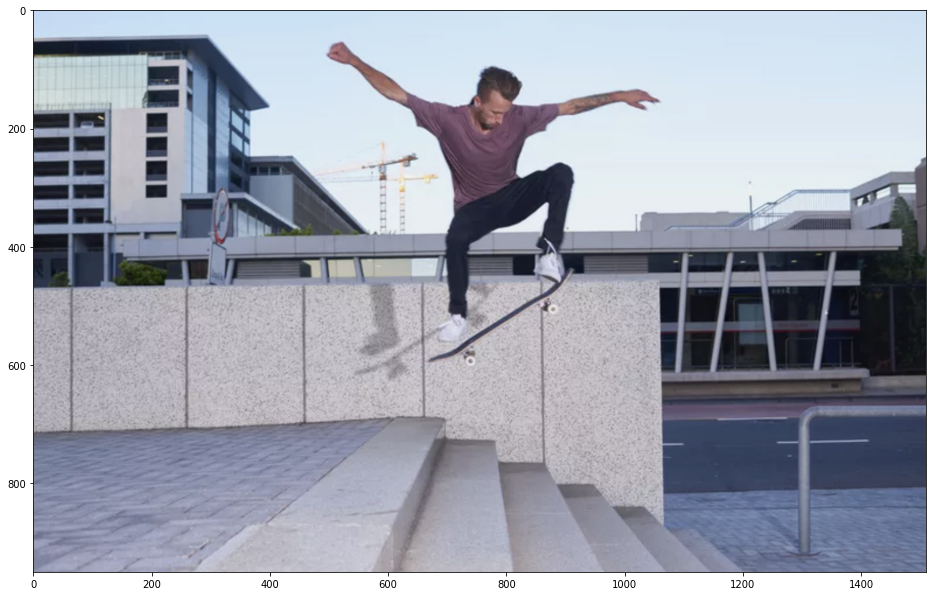

<start> a man is jumping in the air on a skateboard . <end>


In [ ]:
path = "/content/drive/My Drive/Sprint24/DownStairs.jpg"
image = Image.open(path)
plt.figure(figsize=(16, 12))
plt.imshow(np.asarray(image))
plt.show()

!python sample.py --image="/content/drive/My Drive/Sprint24/DownStairs.jpg"

ステアでオーリーしている画像  
→　ジャンプしているという動作が認識できている

# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。  
  
特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

#### MMdnnを使用して学習済みの重みを以下のように変換する
pytorch -> onnx -> keras -> tflite